In [8]:
import torch
!pip install split-folders

In [10]:
import splitfolders

In [12]:
input = "data"
output = "data split"

In [14]:
splitfolders.ratio(input, output=output, seed=1337, ratio=(0.72,0.08,0.2))

Copying files: 38015 files [00:06, 5943.60 files/s]


In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
os.listdir('./data split/train')

['c4',
 'c19',
 'c7',
 'c2',
 'c15',
 'c12',
 'c37',
 'c29',
 'c26',
 'c31',
 'c30',
 'c24',
 'c3',
 'c35',
 'c22',
 'c11',
 'c38',
 'c25',
 'c1',
 'c20',
 'c28',
 'c33',
 'c9',
 'c27',
 'c32',
 'c8',
 'c5',
 'c10',
 'c36',
 'c13',
 'c21',
 'c16',
 'c17',
 'c34',
 'c18',
 'c23',
 'c6',
 'c14']

In [6]:
training_dataset_path="./data split/train"

In [8]:
training_transforms = transforms.Compose([transforms.Resize((52,52)), transforms.ToTensor()])

In [10]:
train_dataset = torchvision.datasets.ImageFolder( root = training_dataset_path, transform = training_transforms)

In [12]:
train_loader = torch.utils.data.DataLoader( dataset = train_dataset, batch_size = 32 , shuffle=False)

In [14]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

In [16]:
mean,std = get_mean_std(train_loader)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
train_dataset_path = './data split/train'
test_dataset_path = './data split/test'
val_dataset_path = './data split/val'

In [19]:


train_transforms = transforms.Compose([
    transforms.Resize((52,52)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((52,52)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

val_transforms = transforms.Compose([
    transforms.Resize((52,52)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])    
    

In [24]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_dataset_path, transform = val_transforms)

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [28]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda"
    else : 
        dev = "cpu"
    return torch.device(dev)

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ratio=16, kernel_size=7):
        super(AttentionBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.channel_attention = ChannelAttention(out_channels, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.conv_block(x)  # Feature Maps (F)
        x = x * self.channel_attention(x)  # Channel Refined Maps (F')
        x = x * self.spatial_attention(x)  # Fully Refined Maps (F'')
        return x

class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        self.conv1 = ConvBlock(1, 256)  # Assuming input image has 1 channel
        self.conv2 = nn.Sequential(
            ConvBlock(256, 256),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            ConvBlock(256, 128),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class AttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionModule, self).__init__()
        self.attention_blocks = nn.ModuleList(
            [AttentionBlock(in_channels if i == 0 else out_channels, out_channels) for i in range(8)]
        )

    def forward(self, x):
        outputs = []
        for attention_block in self.attention_blocks:
            x = attention_block(x)
            outputs.append(x)
        return sum(outputs)

class ClassificationModule(nn.Module):
    def __init__(self, in_features, num_classes):
        super(ClassificationModule, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

class AttentionAugmentedCNN(nn.Module):
    def __init__(self, num_classes=38):
        super(AttentionAugmentedCNN, self).__init__()
        self.conv_module = ConvModule()
        self.attention_module = AttentionModule(128, 128)  # Assuming output of ConvModule is 128 channels
        self.classification_module = ClassificationModule(128, num_classes)

    def forward(self, x):
        x = self.conv_module(x)
        x = self.attention_module(x)
        x = self.classification_module(x)
        return x


In [32]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=inputs.size(-1))
        log_p = F.log_softmax(inputs, dim=-1)
        p = torch.exp(log_p)
        focal_loss = -self.alpha * (1 - p) ** self.gamma * log_p
        focal_loss = focal_loss * targets
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [34]:
import torch.optim as optim

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = AttentionAugmentedCNN().to(device)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets) 
        loss.backward()
        optimizer.step() 
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f'Epoch [{epoch+1}] Loss: {running_loss/len(train_loader):.4f} Accuracy: {100.*correct/total:.2f}%')

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(f'Validation Loss: {running_loss/len(val_loader):.4f} Accuracy: {100.*correct/total:.2f}%')
    return running_loss / len(val_loader)

# Training loop
num_epochs = 10
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, epoch)
    val_loss = validate(model, val_loader, criterion)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
print(f'Test Accuracy: {100.*correct/total:.2f}%')


Epoch [1] Loss: 0.0149 Accuracy: 69.05%
Validation Loss: 0.0070 Accuracy: 81.78%
Epoch [2] Loss: 0.0036 Accuracy: 91.29%
Validation Loss: 0.0025 Accuracy: 93.78%
Epoch [3] Loss: 0.0026 Accuracy: 93.76%
Validation Loss: 0.0014 Accuracy: 96.55%
Epoch [4] Loss: 0.0022 Accuracy: 94.62%
Validation Loss: 0.0018 Accuracy: 96.05%
Epoch [5] Loss: 0.0022 Accuracy: 94.78%
Validation Loss: 0.0025 Accuracy: 93.91%
Epoch [6] Loss: 0.0017 Accuracy: 95.84%
Validation Loss: 0.0024 Accuracy: 95.49%
Epoch [7] Loss: 0.0019 Accuracy: 95.58%
Validation Loss: 0.0022 Accuracy: 95.23%
Epoch [8] Loss: 0.0015 Accuracy: 96.48%
Validation Loss: 0.0012 Accuracy: 97.24%
Epoch [9] Loss: 0.0015 Accuracy: 96.35%
Validation Loss: 0.0017 Accuracy: 95.66%
Epoch [10] Loss: 0.0013 Accuracy: 96.86%
Validation Loss: 0.0017 Accuracy: 96.38%
Test Accuracy: 96.95%


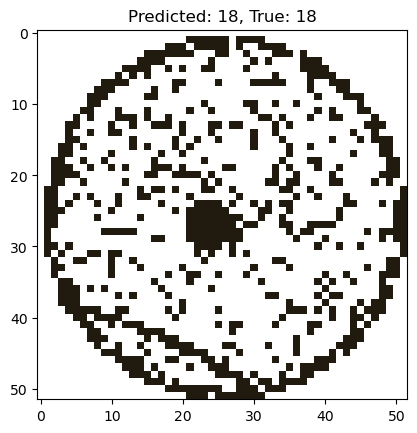

In [59]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

model = AttentionAugmentedCNN()  

model.load_state_dict(torch.load('best_model.pth'))  
model = model.to(device)  

model.eval()


all_images = []
all_labels = []
for batch in test_loader:
    images, labels = batch
    all_images.append(images)
    all_labels.append(labels)

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

index = random.randint(0, len(all_images) - 1)
image = all_images[index]
label = all_labels[index]

image_tensor = image.unsqueeze(0) 
image_tensor = image_tensor.to(device)  


with torch.no_grad():
    output = model(image_tensor)
    _, predicted = torch.max(output.data, 1)

image_np = image.cpu().numpy().transpose((1, 2, 0))  
mean = np.array([0.485, 0.456, 0.406])  
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean 
image_np = np.clip(image_np, 0, 1)


plt.imshow(image_np)
plt.title(f'Predicted: {predicted.item()}, True: {label.item()}')
plt.show()
